In [1]:
import torch
import pandas as pd
import pickle
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score, auc 
from sklearn.metrics import roc_auc_score
import numpy as np
import gc
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import time
import datetime
from scipy.special import softmax
from transformers import AdamW, AutoTokenizer,EsmForSequenceClassification, EsmForTokenClassification
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from transformers import get_linear_schedule_with_warmup
import random
import torch.nn.functional as F
import numpy as np
import io
from sklearn.decomposition import PCA
import itertools
import scipy.stats
import seaborn as sns
import matplotlib.patches as mpatches

### Read protein sequence

In [12]:
seq = input("Enter protein sequence(s) (one letter for amino acid) to predict phase transition propensity \n")
print('\n entered sequence(s):', seq)

Enter protein sequence(s) (one letter for amino acid) to predict phase transition propensity 
MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGF

 entered sequence(s): MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGF


In [16]:
### Tokenizing the sequence
sequence = [seq]

In [20]:
d = {'sequence': sequence}

df = pd.DataFrame(data=d)

# Get the lists of sequences 
sequences = df.sequence.values
sequences

array(['MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGF'],
      dtype=object)

In [21]:
## define tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [22]:
# Tokenize all of the sequences 
input_ids = []
attention_masks = []

# For every sequence...
for seq in sequences:
    # `encode_plus` does:
    #   1. Tokenize the sequence.
    #   2. Place the start token.
    #   3. Append the end token to the end.
    #   4. Pad or truncate the sequence to `max_length`
    #   5. Create attention masks for padding the tokens.
    encoded_dict = tokenizer.encode_plus(
                        seq,                      # sequence to encode.
                        add_special_tokens = True, # Add start and end tokens to begin and end of the sequence
                        max_length = 1100, # Pad & truncate all sequences.  ### !!! 1100
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    # Add the encoded sequence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # and add its attention mask (differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)



# Print sequence 0, as a list of token IDs.
print('Original: ', sequences[0])
print('Token IDs:', input_ids[0])
#print('labels:', labels[0])
print(len(sequences))
print(len(input_ids[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  MSKSESPKEPEQLRKLFIGGLSFETTDESLRSHFEQWGTLTDCVVMRDPNTKRSRGFGFVTYATVEEVDAAMNARPHKVDGRVVEPKRAVSREDSQRPGAHLTVKKIFVGGIKEDTEEHHLRDYFEQYGKIEVIEIMTDRGSGKKRGF
Token IDs: tensor([ 0, 20,  8,  ...,  1,  1,  1])
1
1100


/gpfs/gibbs/pi/gerstein/mbf34/conda_envs/env_name2/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### Masking regions in the protein seqeunce (optional)

In [1]:
### Optional ### if the user would like to make predictions while masking some positions###
def masking_regions(attention_masks):
    
    ## user put the region in sequence to mask:
    start_mask = 500
    end_mask = 600
    
    mask = torch.tensor([i for i in range(start_mask,end_mask)]) # masking range
    attention_masks[:, mask] = 0
    
    return (attention_masks)

In [ ]:
### optional!!! user run this cell to mask regions within the sequence
attention_masks = masking_regions(attention_masks)

### make predictions of protein phase transition by the fine-tuned ESMFold:
(1) for classification task A (+Droplet drivers & +Amyloids versus -PT) user should choose: final_files/ESM_das_final.pth. Amino acid sequences with labels:  0 +Droplet drivers & +Amyloids 1 -PT

(2) for classification task B (+Droplet drivers & +Amyloids versus -PT) user should choose: 
final_files/ESM_DA_final.pth. Amino acid sequences with labels: 0 - +Amyloids 1 - +Droplet drivers

In [24]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [41]:
# ==========================================================================
#               test on external test set usge: 3 cores & 3 nodes with 1 gpu
# ==========================================================================

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

#del saved_model 
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

## load a model to predict +Droplet drivers & +Amyloids versus -PT
#saved_model = torch.load('final_files/ESM_das_final.pth',  map_location=torch.device('cpu')) 


## load a model to predict +droplet drivers versus +amyloids
saved_model = torch.load('final_files/ESM_DA_final.pth',  map_location=torch.device('cpu')) 


#turn off for unlabeled seqeunces (such as AMP-AD sequences)
## use only for labeled sequences - to load the external text set
#train_dataloader, validation_dataloader = get_train_test_data(train_dataset_idx, val_dataset_idx, 
                                                              #input_ids, attention_masks, labels)


## for unlabeled sequences
val_dataset = TensorDataset(input_ids, attention_masks)
validation_dataloader = DataLoader(dataset=val_dataset)
    
print("")
print("Running Prediction...")

t0 = time.time()

# Put the model in evaluation mode
saved_model.eval()

# Tracking variables 
predicted_class_id_all = []
probabilities_all = []
label_ids_all = []
predicted_param =[]
logits_all = []
logits_save = []
results_all = []

# make predictions for all batches (1 epoch)
for batch in validation_dataloader:
        
        # Unpack the test batch from our dataloader and copy to the GPU. 
            #    0: input ids 
            #    1: attention masks
            #    2: labels    #### not used for unlabeled sequences
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        
        
        # Gradients are not computed 
        with torch.no_grad():        

            #load saved model
            results = saved_model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                  output_hidden_states = True, output_attentions=True)
            results_all.append(results.hidden_states)

        # Move logits and labels to CPU
        #logits = logits.detach().cpu().numpy()
        logits = torch.detach(results.logits[0])
        

        ## accumulate predicted classes, logits and true labels from all the batches
        predicted_class_id = [results.logits[i].argmax().item() for i in range(0, len(results.logits))]
        logits_all.append(results.logits)
        predicted_class_id = [results.logits[i].argmax().item() for i in range(0, len(results.logits))]
        predicted_class_id_all.extend(predicted_class_id)
        
    
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("Prediction took: {:}".format(validation_time))
        print('\n predicted logits are', logits)
        
        
        ### Compute transition score
        for i in logits_all:
            logits_save.append(i[0].tolist())
        probabilities = softmax(logits_save, axis=1)
        print('\n predicted probabilities',probabilities)
        
        LLM_score = []
        for i in probabilities:   
            LLM_score.append(np.log(i[0]/i[1]))
        print('transition score:', LLM_score)


Running Prediction...
Prediction took: 0:00:00

 predicted logits are tensor([-0.7458,  0.9647])

 predicted probabilities [[0.15310633 0.84689367]]
transition score: [-1.7104424834251404]


### Extract Attention map

In [45]:
def self_attention(predicted_results, seq_len):
    
    "input: predicted_results: model output (predictions),seq_len: sequence length"
    "Output: mean self attention map of all the 20 attention heads"
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax=ax.matshow((predicted_results.mean(0)[:seq_len,:seq_len])   ##plt
                , vmin=0, vmax=0.1 ,cmap=plt.cm.Spectral_r)
    
    # Set xticks and yticks
  
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=17)
    
    #plt.xlim(0,50)
    #plt.ylim(50,0)
    
    startp=0
    endp=10     # true lenght of the sequence
    plt.xlim(startp+1,endp-1)
    plt.ylim(endp-1,startp+1)
    
    
    plt.box(False)
    plt.tick_params(bottom = False)
    #cbar=plt.colorbar(shrink=0.8)
    cbar=fig.colorbar(cax,shrink=0.8)
    cbar.set_label(label='Attention score', fontsize=17)
    cbar.ax.tick_params(labelsize=17)
    
    ax.set(xticks=[i for i in range (startp,endp+1,2)], xticklabels= [i for i in range (startp+1,endp+2,2)],
           yticks=[i for i in range (startp,endp+1,2)], yticklabels= [i for i in range (startp+1,endp+2,2)])
    
    # for plotting 0-50
    #ax.set(xticks=[i for i in range (startp,endp,20)], xticklabels= [i for i in range (startp,endp,20)],
           #yticks=[i for i in range (startp,endp,20)], yticklabels= [i for i in range (startp,endp,20)])
  
        
    print((predicted_results.mean(0)[:seq_len,:seq_len])[startp:endp,startp:endp])
    my_mat = (predicted_results.mean(0)[:seq_len,:seq_len])[startp:endp,startp:endp]
    print(my_mat.shape)
   
    return(my_mat)

tensor([[0.2464, 0.1091, 0.0679, 0.0455, 0.0365, 0.0222, 0.0202, 0.0152, 0.0187,
         0.0108],
        [0.2584, 0.1560, 0.0818, 0.0615, 0.0492, 0.0318, 0.0327, 0.0172, 0.0208,
         0.0086],
        [0.2020, 0.1820, 0.0887, 0.0624, 0.0708, 0.0408, 0.0330, 0.0209, 0.0217,
         0.0086],
        [0.1428, 0.1424, 0.1089, 0.0691, 0.0644, 0.0517, 0.0483, 0.0310, 0.0256,
         0.0122],
        [0.1266, 0.1210, 0.0699, 0.1060, 0.0783, 0.0451, 0.0485, 0.0408, 0.0283,
         0.0160],
        [0.1045, 0.0859, 0.0745, 0.0612, 0.1008, 0.0583, 0.0574, 0.0514, 0.0432,
         0.0213],
        [0.1074, 0.0700, 0.0466, 0.0759, 0.0664, 0.1020, 0.0752, 0.0482, 0.0481,
         0.0347],
        [0.0893, 0.0474, 0.0277, 0.0547, 0.0747, 0.0616, 0.1002, 0.0567, 0.0439,
         0.0308],
        [0.0697, 0.0322, 0.0161, 0.0305, 0.0356, 0.0525, 0.0545, 0.0834, 0.0830,
         0.0353],
        [0.0518, 0.0321, 0.0159, 0.0273, 0.0240, 0.0369, 0.0568, 0.0440, 0.0940,
         0.0395]])
torch.Siz

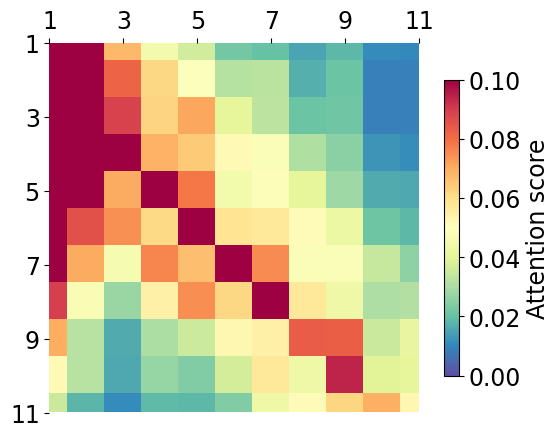

In [46]:
### calculate self attention map
my_matA = self_attention(results['attentions'][5][0],  b_input_ids.shape[1])